# Assignment 7

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

Additional note:

* You can complete this assignment using either your local machine or Google Colab. Your solution for this assignment should be able to run on the <span style="color:red">FREE version</span> of Google Colab. If you find that you need to upgrade to the paid version, it indicates that there is an inefficiency in your code.
---

#### ``Objectives``
1. Implement a Decision Forest for land cover classification

#### ``Motivation``

Land cover classification using machine learning (ML) techniques is important for several reasons, spanning environmental monitoring, resource management, urban planning, disaster response, and scientific research. 

#### ``Data``

In this assignment, you will use the EuroSAT dataset, consisting of Sentinel-2 RGB satellite images of 10 classes with 27000 labeled and geo-referenced samples. 

The dataset is hosted by [TensorFlow Data Collections](https://www.tensorflow.org/datasets/catalog/eurosat). To avoid any data versioning issues, we have downloaded the data for you (please see below).

`Download` link: [images + labels](https://drive.google.com/file/d/131GuYn092OlWKGopsT8arQoDreneU7SZ/view?usp=share_link). Once you unzip the file, you will see that the name of each subfolder represents the land cover classes.

---

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import random

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil
import pathlib
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning) #used to supress the tf version warning. 

# FILL IN CODE HERE #
DATA_PATH = r"C:\Users\tgeod\Downloads\UC Berkeley\DATASCI 207 - Applied Machine Learning\Week 7 - KNN, Decision Trees, and Ensembles\HW 7\EuroSAT\EuroSAT"


^ make sure to replace DATA_PATH with the path to the directory where you saved the data.

---
### Step 1: Data ingestion

#### <span style="color:chocolate"> Exercise 1 (10 points) </span>

Let's load the 2D images and their corresponding labels. Implement the <span style="color:chocolate">load_data()</span> function below according to the following guidelines:
- to read label and image names: use the <span style="color:chocolate">os</span> library (in particular the <span style="color:chocolate">os.listdir()</span> and <span style="color:chocolate">os.path.join()</span> methods);
- to load an image: use the <span style="color:chocolate">load_image()</span> method (see list of imported libraries);
- to transform images to arrays: use the <span style="color:chocolate">img_to_array()</span> method (see list of imported libraries).

In [2]:
def load_data(path_to_data):
    '''Load 2D images and their corresponding labels
    Parameters:
    path_to_data (str): This is the path to data
    
    Returns:
    images (np.ndarray): A numpy array of shape (N, 64, 64, 3)
    labels (np.ndarray): A numpy array of shape (N)
    
    '''
    ## load images and labels
    # FILL IN CODE HERE #  
    
    images = []
    labels = []
    
    # Get list of all directories (each directory is a label)
    dir_list = os.listdir(path_to_data)
    
    for label in dir_list:
        label_path = os.path.join(path_to_data, label)
        
        if os.path.isdir(label_path):
            # Get list of all files in the directory
            file_list = os.listdir(label_path)
            
            for file in file_list:
                file_path = os.path.join(label_path, file)
                
                # Load the image
                image = load_img(file_path, target_size=(64, 64))
                
                # Convert the image to an array
                image_array = img_to_array(image)
                
                # Append image array and label to respective lists
                images.append(image_array)
                labels.append(label)
    
    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels





In [3]:
# Load images and labels. Print shapes

images, labels = load_data(DATA_PATH)
print("Shape of images ", images.shape)
print("Shape of labels ", labels.shape)

Shape of images  (27000, 64, 64, 3)
Shape of labels  (27000,)


---
### Step 2: Exploratory data analysis (EDA)

#### <span style="color:chocolate"> Exercise 2 (10 points) </span>

Plot the land cover class distribution. Are the classes balanced?

C:\Users\tgeod\AppData\Local\Temp\ipykernel_29288\59531981.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()), palette="viridis")


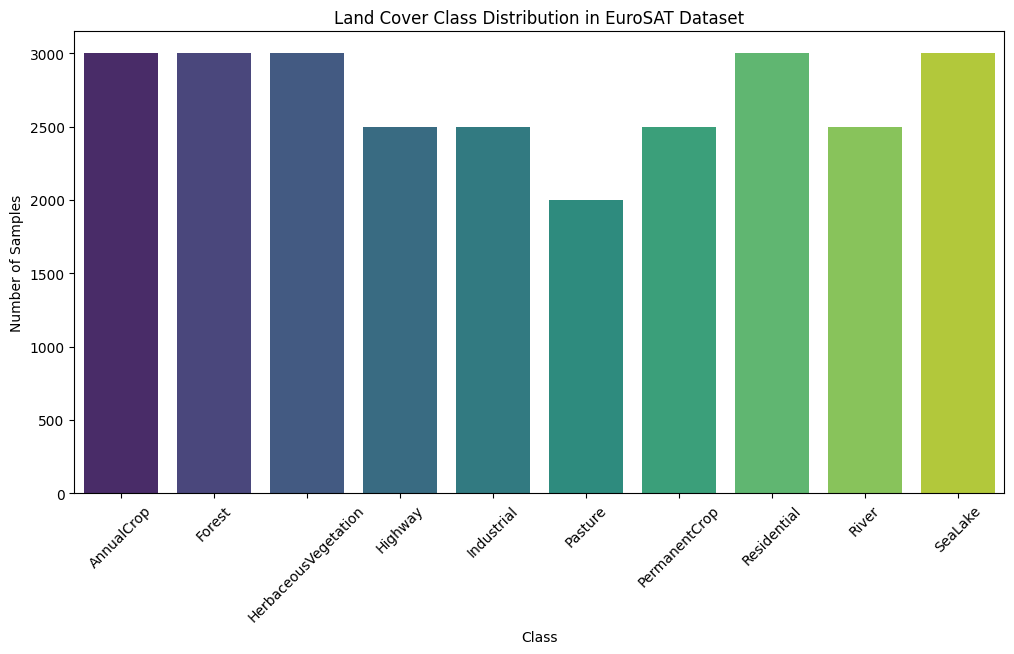

In [4]:
# FILL IN CODE HERE # 
# Count the number of samples per class
unique, counts = np.unique(labels, return_counts=True)

#creating a dictionary of class, counts
class_distribution = dict(zip(unique, counts))

# Plotting class distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()), palette="viridis")
plt.title('Land Cover Class Distribution in EuroSAT Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()



Comment on class balance: The classes are roughly balanced except for the pasture class. 

#### <span style="color:chocolate"> Exercise 3 (10 points) </span>

Inspect (print) one image from each class. What land classes do you think a Decision Tree classifier is more likely to confuse?

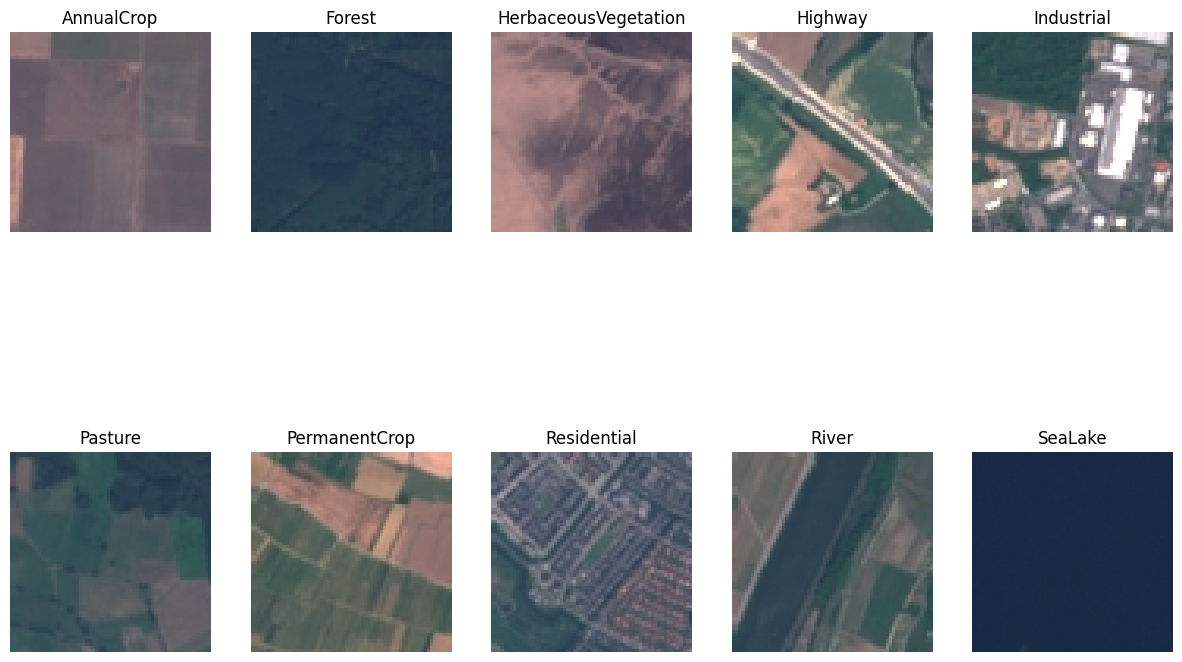

In [5]:
# FILL IN CODE HERE #
# Initialize a dictionary to store images by class
class_images = {}

# Iterating through the dataset
for class_name in os.listdir(DATA_PATH):
    class_dir = os.path.join(DATA_PATH, class_name)
    if os.path.isdir(class_dir):
        # Finding the first image in the directory
        for file_name in os.listdir(class_dir):
            if file_name.endswith('.jpg') or file_name.endswith('.png'):
                image_path = os.path.join(class_dir, file_name)
                image = load_img(image_path, target_size=(64, 64))
                class_images[class_name] = image
                break  # Only take the first image

# Plotting the images
plt.figure(figsize=(15, 10))
for i, (class_name, image) in enumerate(class_images.items()):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis('off')

plt.show()

Most confused land classes: [Forest and SeaLake appear to be the most confused classes]

---
### Step 3: Data preprocessing

Encode labels

In [6]:
encoder = LabelEncoder().fit(list(set(labels))) # fit on unique labels
encoded_labels = encoder.transform(labels) # apply to labels array (will get labels from 0 to 9)
encoded_labels_classes = list(encoder.classes_) # store mapping generated by the encoder

#### <span style="color:chocolate"> Exercise 4 (10 points) </span>

Create train, validation, and test data. Implement the <span style="color:chocolate">split_data()</span> function below according to the following guidelines:
- shuffle images and labels before spliting the data;
- use a 60/20/20 split.

In [7]:
def split_data(images, labels, split):
    '''Split data into train, validation and test sets.
    
    Parameters:
    images  (np.ndarray): Images of shape (N, 64, 64, 3)
    labels (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    X_train (np.ndarray): Train images of shape (N_train, 64, 64, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 64, 64, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 64, 64, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    '''
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(1234)
    np.random.seed(1234)
    
    # shuffle data
    # FILL IN CODE HERE #
    
    indices = np.arange(len(images))
    np.random.shuffle(indices)
    images = images[indices]
    labels = labels[indices]
    
    # create data splits
    # FILL IN CODE HERE #
    
    # Calculate split sizes
    num_samples = len(images)
    train_split = int(split[0] * num_samples)
    val_split = int(split[1] * num_samples)
    
    # Split data
    X_train, y_train = images[:train_split], labels[:train_split]
    X_val, y_val = images[train_split:train_split + val_split], labels[train_split:train_split + val_split]
    X_test, y_test = images[train_split + val_split:], labels[train_split + val_split:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test
 

In [8]:
# define splits
split = (0.6, 0.2, 0.2)

# create train, val, test sets
X_train, y_train, X_val, y_val, X_test, y_test = split_data(images, encoded_labels, split)

# print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)

print('Shape of val images ', X_val.shape)
print('Shape of train labels ', y_val.shape)

print('Shape of test images ', X_test.shape)
print('Shape of test labels ', y_test.shape)

Shape of train images  (16200, 64, 64, 3)
Shape of train labels  (16200,)
Shape of val images  (5400, 64, 64, 3)
Shape of train labels  (5400,)
Shape of test images  (5400, 64, 64, 3)
Shape of test labels  (5400,)


#### <span style="color:chocolate"> Exercise 5 (10 points) </span>

Perform image transformation and augmentation. 

<span style="color:green"> Step 1: </span> Implement the <span style="color:chocolate">data_preprocessing()</span> function below according to the following guidelines:

- Applied on training set only: 
    - create additional copies of the training images by applying the following augmentation techniques to each image: adjust brightness by adding DELTA=0.3 to the pixel values, then adjust contrast to CONTRAST_FACTOR=3, then flip left right (Hint: use the methods available in the tf.image module);
    - concatenate the augmented images to the original training images. Note that the train set should be double in size after data augmentation, i.e., 32400 images and labels;
    
    
- Applied on training, validation, and test sets: normalize all pixel values by dividing by 255.0.
    
<span style="color:green"> Step 2: </span> Comment on the importance of adding augmented images to training data (be sure to justify why you don't augment the validation and test sets as well).

In [9]:
def data_preprocessing(X, y, data_partition='train'):
    '''Apply transformations and augmentations to training, validation, and test dat;
    
    Parameters:
    X  (np.ndarray): Images of shape (N, 64, 64, 3)
    y (np.ndarray): Labels of shape (N,)   
    data_partition (str): "train"
    
    Returns:
    X (np.ndarray): Preprocessed images of shape (N, 64, 64, 3)
    y (np.ndarray): Labels of shape (N,)
    
    '''

    CONTRAST_FACTOR = 3
    DELTA = 0.3
    
    # image augmentation on training data
    if data_partition=="train":
        # adjust brightness
        X_augm = tf.image.adjust_brightness(X, delta= DELTA) 

        # adjust contrast
        X_augm = tf.image.adjust_contrast(X_augm, contrast_factor=CONTRAST_FACTOR) 

        # random flip
        X_augm = tf.image.flip_left_right(X_augm) 

        # concatenate original X and augmented X_aug data
        X = tf.concat([X,X_augm],axis=0) 

        # concatenate y_train (note the label is preserved)
        y_augm = y
        y = tf.concat([y, y_augm],axis=0)

        # shuffle X and y, i.e., shuffle two tensors in the same order
        shuffle = tf.random.shuffle(tf.range(tf.shape(X)[0], dtype=tf.int32))
        X = tf.gather(X, shuffle).numpy() # transform X back to numpy array instead of tensor
        y = tf.gather(y, shuffle).numpy() # transform y back to numpy array instead of tensor
        
        
    # rescale image by dividing each pixel by 255.0 
    X/=255.0
    
    return X, y

Comment on the importnace of adding augmented images to training data (be sure to justify why you don't augment the validation and test sets as well): Augmentation increases the size of training dataset and introduces variations which helps the model generalize better. In dataset where some classes do not have enough sample, augmentation can help balance the classes by generating more examples of the underrepresentated classes. Augmenting test and validation dataset can introduce data leakage, and since the primary purpose of test nad validation data is to evaluate how well a model generalizes to unseen data, augmented test and validation data will not serv that purpose. 

In [10]:
# apply data preprocessing
X_train, y_train = data_preprocessing(X_train, y_train, data_partition='train')
X_val, y_val = data_preprocessing(X_val, y_val, data_partition='val')
X_test, y_test = data_preprocessing(X_test, y_test, data_partition='val')

# print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val.shape)
print('Shape of test images ', X_test.shape)

Shape of train images  (32400, 64, 64, 3)
Shape of train labels  (32400,)
Shape of val images  (5400, 64, 64, 3)
Shape of test images  (5400, 64, 64, 3)


Reshape training, val, and test data (to be compatible with sklearn Decision Forests)

In [11]:
# compute number of features (multiply RGB features)
features_shape = X_train[:, :, :, 0].shape[1] * X_train.shape[2] * X_train.shape[3]
print('Total number of features used for Decision Forests', features_shape)

# reshape data
X_train_re = X_train.reshape(X_train.shape[0], features_shape)
X_val_re = X_val.reshape(X_val.shape[0], features_shape)
X_test_re = X_test.reshape(X_test.shape[0], features_shape)

# print shapes
print('Shape of train images ', X_train_re.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val_re.shape)
print('Shape of test images ', X_test_re.shape)

Total number of features used for Decision Forests 12288
Shape of train images  (32400, 12288)
Shape of train labels  (32400,)
Shape of val images  (5400, 12288)
Shape of test images  (5400, 12288)


---
### Step 4: Modeling

#### <span style="color:chocolate"> Exercise 6 (10 points) </span>

Implement a Decision Forest classifier according to the following guidelines (let's call this model our baseline classifier):
    
- Use the <span style="color:chocolate">RandomForestClassifier</span> class available in the <span style="color:chocolate">sklearn.ensemble</span> module;
- Set the following argument values:
    - n_estimators=2,
    - n_jobs=1
    - random_state=7
    - max_depth=8
- Train the model on (X_train_re, y_train) data;
- Evaluate the accuracy of the model on (X_train_re, y_train) and (X_val_re, y_val) data. Comment on model performance on training vs. validation datasets. Does the model generalize well?
- Plot the confusion matrix using (y_val, y_val_pred) data. Comment on the classes that the model confuses the most.

Training Accuracy: 0.4696
Validation Accuracy: 0.4489


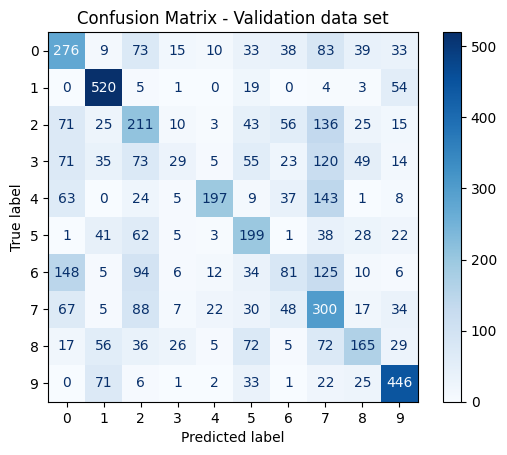

In [12]:
### YOUR CODE HERE ###
from sklearn.ensemble import RandomForestClassifier

# Initializing the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=2, n_jobs=1, random_state=7, max_depth=8)

# Training the model on training data
rf_classifier.fit(X_train_re, y_train)

# Evaluating model on training data
y_train_pred = rf_classifier.predict(X_train_re)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Evaluating model on validation data
y_val_pred = rf_classifier.predict(X_val_re)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Plotting confusion matrix for validation data
cm = confusion_matrix(y_val, y_val_pred)
labels = np.unique(y_val)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
cm_display.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Validation data set')
plt.show()


In [13]:
# Checking mapping of numeric labels to class names
for i, class_name in enumerate(encoded_labels_classes):
    print(f"Label {i} corresponds to class name: {class_name}")


Label 0 corresponds to class name: AnnualCrop
Label 1 corresponds to class name: Forest
Label 2 corresponds to class name: HerbaceousVegetation
Label 3 corresponds to class name: Highway
Label 4 corresponds to class name: Industrial
Label 5 corresponds to class name: Pasture
Label 6 corresponds to class name: PermanentCrop
Label 7 corresponds to class name: Residential
Label 8 corresponds to class name: River
Label 9 corresponds to class name: SeaLake


Comment on model accuracy on training vs. validation data: Accuracy on training data is 0.4696 and the accuracy on validation data is 0.4489

Does the model generalize well?: The validation accuracy is closer to the training accuracy which shows the model generalizes well.

Comment on the classes that the model confuses the most: In general, the model confuses residential classes the most. From the confusion matrix it can be seen that almost all true classes confuses residential class the most. For a partical class to class confusion, PermanentCrop class confuses the AnnualCrop class the most.

#### <span style="color:chocolate"> Exercise 7 (20 points) </span>

Implement a Decision Forest classifier that improves the training and validation set accuracy performance of the baseline model implemented above by at least 10% (the more you can improve the better). Also, the performance difference between the training and validation sets should be at most 10%. Be sure to follow these guidelines: 
    
- Use the <span style="color:chocolate">RandomForestClassifier</span> or the <span style="color:chocolate">GradientBoostingClassifier</span> available in the <span style="color:chocolate">sklearn.ensemble</span> module
- Be explicit on how your implementation is different compared to the baseline classifier:
    - different argment values for the baseline model (RandomForestClassifier)?
    - different Decision Forest classifier?
    - different data preprocessing procedure?
    - a combination of the three points above
    - anything else?
- Train the model on (X_train_re, y_train) data.
- Evaluate the model's accuracy on (X_val_re, y_val) data. Comment on training vs. validation performance relative to baseline model.
- Plot confusion matrix using the (y_val, y_val_pred) data. Comment on the classes the model confuses the most relative to the baseline.

In [14]:
##rf_clf2 = ''
### YOUR CODE HERE ###
from sklearn.ensemble import GradientBoostingClassifier

# Initialize Gradient Boosting Classifier with tuned parameters
gb_classifier = GradientBoostingClassifier(n_estimators=4, learning_rate=0.1, max_depth=5, subsample=0.8, random_state=7)

# Train the model on training data
gb_classifier.fit(X_train_re, y_train)

# Evaluating model on training data
y_train_pred_gb = gb_classifier.predict(X_train_re)
train_accuracy_gb = accuracy_score(y_train, y_train_pred_gb)
print(f"Gradient Boosting - Training Accuracy: {train_accuracy_gb:.4f}")

# Evaluating model on validation data
y_val_pred_gb = gb_classifier.predict(X_val_re)
val_accuracy_gb = accuracy_score(y_val, y_val_pred_gb)
print(f"Gradient Boosting - Validation Accuracy: {val_accuracy_gb:.4f}")

# Plotting confusion matrix for validation data
cm_gb = confusion_matrix(y_val, y_val_pred_gb, labels=np.unique(y_val))
cm_display_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb, display_labels=encoded_labels_classes)
plt.figure(figsize=(10, 8))
cm_display_gb.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Gradient Boosting (Validation Set)')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks(rotation=45)
plt.show()


Training Accuracy: 0.5554
Validation Accuracy: 0.4985


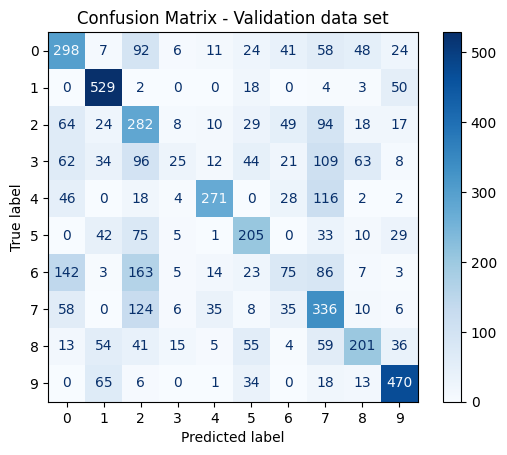

In [19]:
### YOUR CODE HERE ###
from sklearn.ensemble import RandomForestClassifier

# Initializing the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=6, n_jobs=1, random_state=7, max_depth=8)

# Training the model on training data
rf_classifier.fit(X_train_re, y_train)

# Evaluating model on training data
y_train_pred = rf_classifier.predict(X_train_re)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Evaluating model on validation data
y_val_pred = rf_classifier.predict(X_val_re)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Plotting confusion matrix for validation data
cm = confusion_matrix(y_val, y_val_pred)
labels = np.unique(y_val)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
cm_display.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Validation data set')
plt.show()



How your implementation is different compared to the baseline classifier: The number of decision trees increased from 2 in baseline classifier to 6.

Comment on training vs. validation performance relative to baseline model: The training accuracy increase from 0.4696 to 0.5554 and the validation accuracy increased from 0.4489 in baseline to 0.4985

Comment on the classes the model confuses the most relative to the baseline: PermanentCrop confuses with HerbaceousVegetation class the most in the new model. However, overall, the model confuses residential classes the most just like in baseline model. From the confusion matrix it can be seen that almost all true classes confuses residential class the most.

---
### Step 5: Evaluation and Generalization

#### <span style="color:chocolate"> Exercise 8 (2 points) </span>

Report accuracy performance on the test data using the model trained for Exercise 7. How does the test set performance compare with the one reported for the training and validation sets?

In [20]:
### YOUR CODE HERE ###

# Evaluating model on test data
y_test_pred = rf_classifier.predict(X_test_re)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")





Test Accuracy: 0.5031


Comment on test set accuracy vs. training vs. validation set accuracy: The test accuracy is 0.5031 which is slightly better than the validation accuracy and is less than 10% of the training accuracy. 

---
### Step 6: Discussion

#### <span style="color:chocolate"> Exercise 9 (8 points) </span>

Would you recommend a Decision Forest for land cover classification? Why or why not?

In [ ]:
### YOUR ANSWER HERE ###
'''Decision Forest for this land cover classification has relatively low accuracy. Increasing the decision trees increases the 
accuracy of training dataset, but the performance difference between the training and validation/test dataset
becomes high. I would not recommend this for land cover classification.'''

#### <span style="color:chocolate"> Exercise 10 (10 points) </span>

What other ML model would you propose to improve performance over the Decision Forest classifier you implemented for Exercise 7?

In [ ]:
### YOUR ANSWER HERE ###
'''Convolutional Neural Network would be an ideal choice over decision forest classifier to improve the performance. 
 It is designed to process image data, capture spatial hierarchies and local patterns through convolutional layers. This
 give it higher accuracy.'''

---
#### <span style="color:chocolate"> Bonus question (20 points) </span>

Implement the idea proposed for Exercise 10. Perform hyperparameter tuning using the training and validation sets, then report the model performance on the test data. Does your model generalize well?

In [21]:
### YOUR CODE HERE ###
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Data preprocessing and augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    DATA_PATH,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    DATA_PATH,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Load pre-trained ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Unfreeze some layers and fine-tune
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Evaluate on validation data
val_preds = model.predict(validation_generator)
val_preds_classes = val_preds.argmax(axis=1)
val_true_classes = validation_generator.classes

val_accuracy = accuracy_score(val_true_classes, val_preds_classes)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Confusion matrix
cm = confusion_matrix(val_true_classes, val_preds_classes)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator.class_indices.keys())
cm_display.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Validation Set')
plt.show()


Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step
Epoch 1/10
